# Calculating and Visualizing Total Carbon Emissions through Time


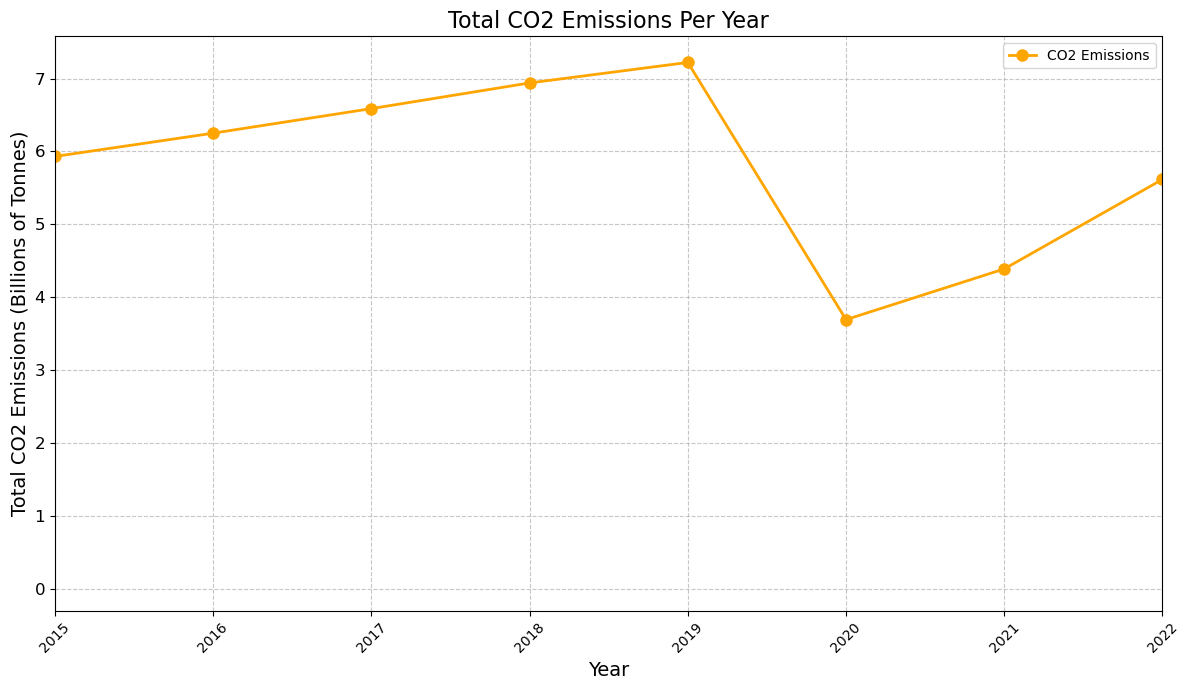

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "/Users/anand/Downloads/Natural_Science_Dataset.xlsx"
excel_data = pd.ExcelFile(file_path)

# Load data from the relevant sheet
sheet_data = pd.read_excel(excel_data, sheet_name='Sheet 1 - AIRTRANS_CO2_17062024')

# Replace '#' with NaN and convert the 'Value' column to numeric, forcing errors to NaN
sheet_data['Value'] = pd.to_numeric(sheet_data['Value'].replace('#', pd.NA), errors='coerce')

# Drop rows where 'TIME' is NaN
sheet_data = sheet_data.dropna(subset=['TIME'])

# Convert TIME to string to ensure we can filter properly
sheet_data['TIME'] = sheet_data['TIME'].astype(str)

# Filter out rows where 'TIME' does not represent a full year
sheet_data = sheet_data[sheet_data['TIME'].str.match(r'^\d{4}$')]

# Drop any remaining rows with NaN values after filtering
sheet_data = sheet_data.dropna(subset=['TIME'])

# Convert TIME to a string format, and extract only the year
sheet_data['YEAR'] = pd.to_datetime(sheet_data['TIME'], errors='coerce').dt.year

# Group by year and sum the emissions
total_emissions_per_year = sheet_data.groupby('YEAR')['Value'].sum().reset_index()

# Convert the emissions values to billions for better readability
total_emissions_per_year['Value'] = total_emissions_per_year['Value'] / 1e9

plt.figure(figsize=(12, 7))
plt.plot(total_emissions_per_year['YEAR'], total_emissions_per_year['Value'], 
         marker='o', color='orange', linestyle='-', linewidth=2, markersize=8, label='CO2 Emissions')

# Add titles and labels
plt.title('Total CO2 Emissions Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total CO2 Emissions (Billions of Tonnes)', fontsize=14)

# Customize ticks
plt.xticks(total_emissions_per_year['YEAR'].unique(), rotation=45)
plt.xlim(2015,2022)
plt.yticks(fontsize=12)
plt.grid(linestyle='--', alpha=0.7)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Calculating and Visualizing Countries with Highest Carbon Emissions in 2022

In [75]:
# Load the Excel file
file_path = "/Users/anand/Downloads/Natural_Science_Dataset.xlsx"
excel_data = pd.ExcelFile(file_path)

# Load data from the relevant sheet
sheet_data = pd.read_excel(excel_data, sheet_name='Sheet 1 - AIRTRANS_CO2_17062024')

# Filter the dataset for the year 2022
emissions_2022 = sheet_data[sheet_data['TIME'] == 2022]

# Group by country and sum the emissions
top_emissions_2022 = emissions_2022.groupby(['Country'])['Value'].sum().reset_index()

# Sort in descending order to get the top emitters
top_emissions_2022 = top_emissions_2022.sort_values(by='Value', ascending=False).head(10)

# Display the result
print(top_emissions_2022)

                          Country         Value
173                 United States  1.500890e+09
33   China (People's Republic of)  3.642133e+08
172                United Kingdom  2.358791e+08
171          United Arab Emirates  2.331076e+08
60                        Germany  1.883930e+08
57                         France  1.700685e+08
168                       Türkiye  1.629893e+08
79                          Japan  1.523236e+08
71                          India  1.387203e+08
29                         Canada  1.307103e+08


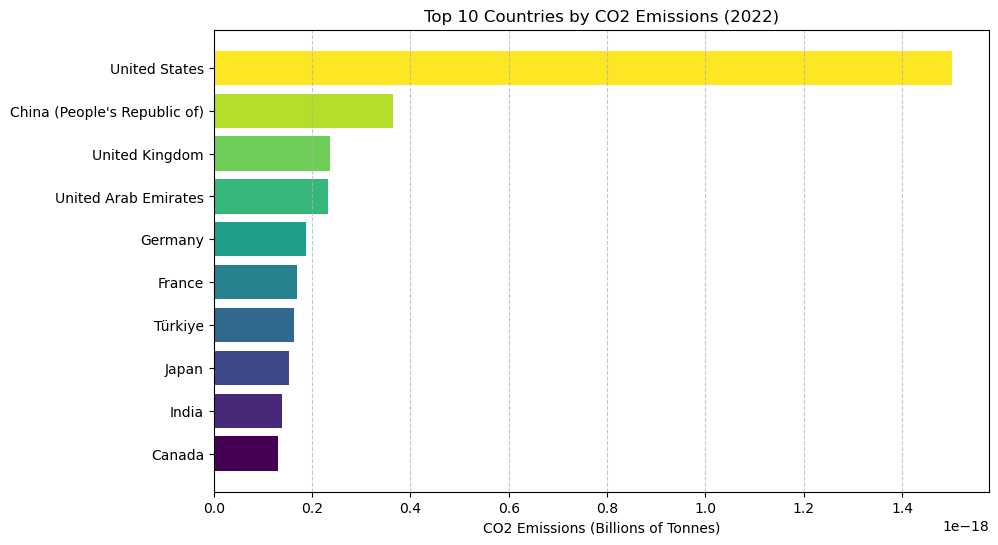

In [81]:
import numpy as np

# Divide the emissions values by 1 billion to convert to billions
top_emissions_2022['Value'] = top_emissions_2022['Value'] / 1e9

# Sort data in descending order for better visualization
top_emissions_2022 = top_emissions_2022.sort_values(by='Value', ascending=True)

# Generate a color for each country using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, top_emissions_2022.shape[0]))

# Plotting—Utilized ChatGPT to help me create this graph and to color code it
plt.figure(figsize=(10, 6))
plt.barh(top_emissions_2022['Country'], top_emissions_2022['Value'], color=colors)
plt.xlabel('CO2 Emissions (Billions of Tonnes)')
plt.title('Top 10 Countries by CO2 Emissions (2022)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Calculating Relationship Between GDP Per Capita and Carbon Emission

In [90]:
# GDP data (ensure country names match your emissions DataFrame)
gdp_data = {
    'Country': ['United States', "China (People's Republic of)", 'United Kingdom', 'United Arab Emirates',
                'Germany', 'France', 'Türkiye', 'Japan', 'India', 'Canada'],
    'GDP': [85373, 13136, 51075, 53916, 54291, 47359, 12765, 33138, 2731, 54866]  # GDP in billions
}

gdp_df = pd.DataFrame(gdp_data)

# Merge the two DataFrames
merged_df = pd.merge(top_emissions_2022, gdp_df, on='Country', how='inner')


                        Country         Value    GDP
0                        Canada  1.307103e-19  54866
1                         India  1.387203e-19   2731
2                         Japan  1.523236e-19  33138
3                       Türkiye  1.629893e-19  12765
4                        France  1.700685e-19  47359
5                       Germany  1.883930e-19  54291
6          United Arab Emirates  2.331076e-19  53916
7                United Kingdom  2.358791e-19  51075
8  China (People's Republic of)  3.642133e-19  13136
9                 United States  1.500890e-18  85373


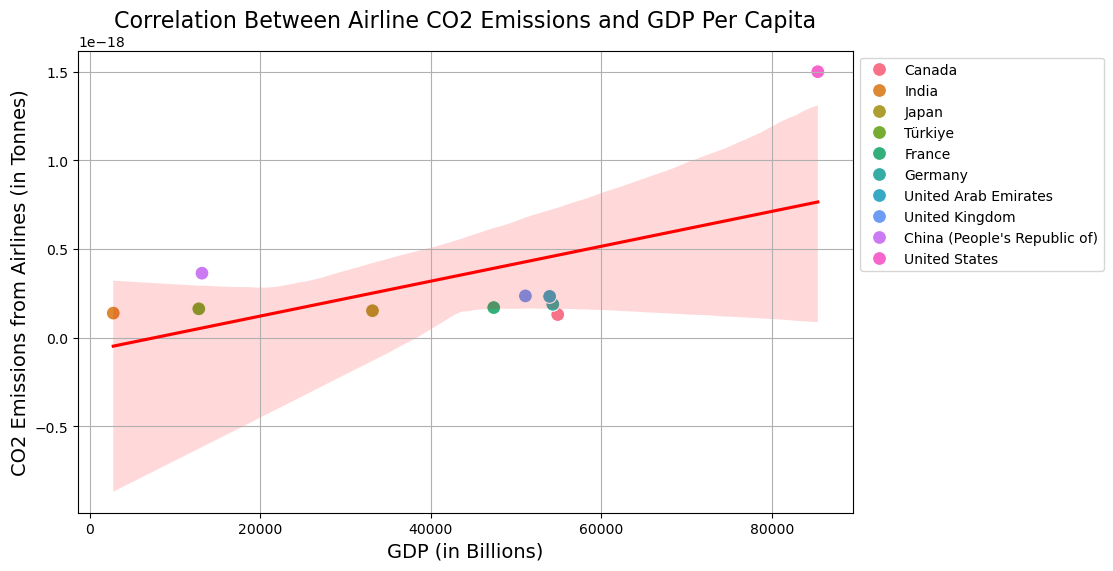

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with a distinct color palette—Utilized ChatGPT 
plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl", len(merged_df))  # or use "Set1" or "coolwarm"
sns.scatterplot(data=merged_df, x='GDP', y='Value', hue='Country', palette=palette, s=100)

# Fit a regression line
sns.regplot(data=merged_df, x='GDP', y='Value', scatter=False, color='red')

plt.title('Correlation Between Airline CO2 Emissions and GDP Per Capita', fontsize=16)
plt.xlabel('GDP (in Billions)', fontsize=14)
plt.ylabel('CO2 Emissions from Airlines (in Tonnes)', fontsize=14)
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend location
plt.show()

In [112]:
# Calculate the correlation coefficient
correlation = merged_df['GDP'].corr(merged_df['Value'])
print(f'Correlation coefficient: {correlation:.2f}')

Correlation coefficient: 0.60


# Projecting Carbon Emissions Until 2030

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the historical CO2 emissions data
historical_data = pd.read_excel("/Users/anand/Downloads/Natural_Science_Dataset.xlsx", sheet_name='Sheet 1 - AIRTRANS_CO2_17062024')


# Filter out necessary columns and convert 'Value' to numeric, replacing '#' with NaN
historical_data['Value'] = historical_data['Value'].replace('#', np.nan).astype(float)

# Drop rows with NaN values in 'Value'
historical_data = historical_data.dropna(subset=['Value'])

# Extract the year from 'TIME' and create a new column
historical_data['YEAR'] = pd.to_datetime(historical_data['TIME'], errors='coerce').dt.year

# Group by year and sum the emissions
yearly_emissions = historical_data.groupby('YEAR')['Value'].sum().reset_index()

# Prepare the data for regression
X = yearly_emissions[['YEAR']]  # Feature
y = yearly_emissions['Value']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for the next few years
future_years = pd.DataFrame({'YEAR': np.arange(2024, 2031)})  # Predict for 2024 to 2030
predictions = model.predict(future_years)

# Create a DataFrame for the predictions
predicted_emissions = pd.DataFrame({'YEAR': future_years['YEAR'], 'Predicted Value': predictions})
# Display only the relevant columns for predictions
predicted_emissions = predicted_emissions[['YEAR', 'Predicted Value']]
print(predicted_emissions)



   YEAR  Predicted Value
0  2024     1.187602e+10
1  2025     1.289105e+10
2  2026     1.390609e+10
3  2027     1.492112e+10
4  2028     1.593616e+10
5  2029     1.695119e+10
6  2030     1.796623e+10


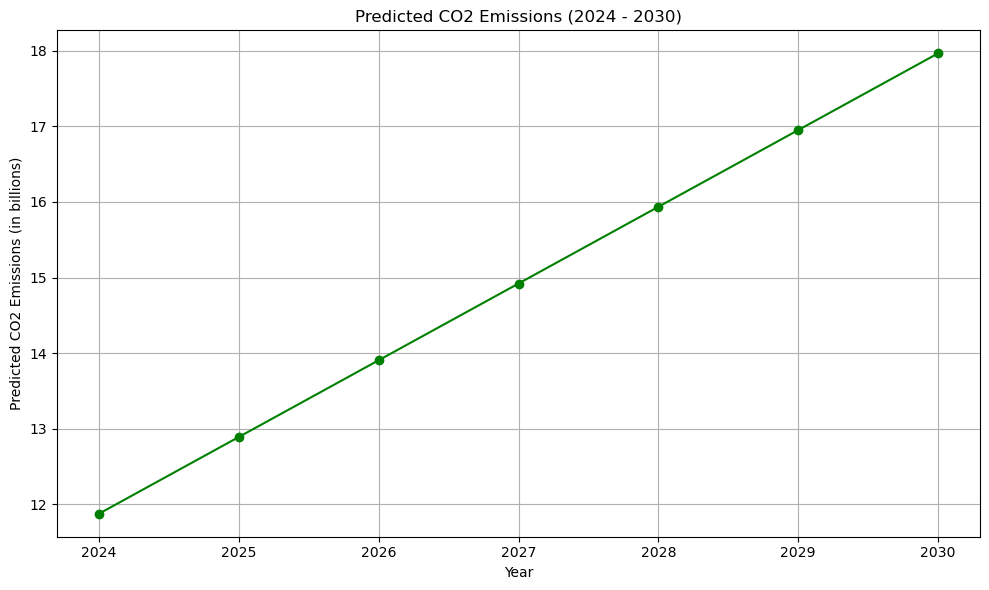

In [126]:
import matplotlib.pyplot as plt

# Divide the predicted values by 1 billion
predicted_emissions['Predicted Value (in billions)'] = predicted_emissions['Predicted Value'] / 1e9

# Plotting the predicted emissions
plt.figure(figsize=(10, 6))
plt.plot(predicted_emissions['YEAR'], predicted_emissions['Predicted Value (in billions)'], marker='o', color='green')
plt.title('Predicted CO2 Emissions (2024 - 2030)')
plt.xlabel('Year')
plt.ylabel('Predicted CO2 Emissions (in billions)')
plt.xticks(predicted_emissions['YEAR'])  # Ensure each year is labeled
plt.grid(True)
plt.tight_layout()
plt.show()


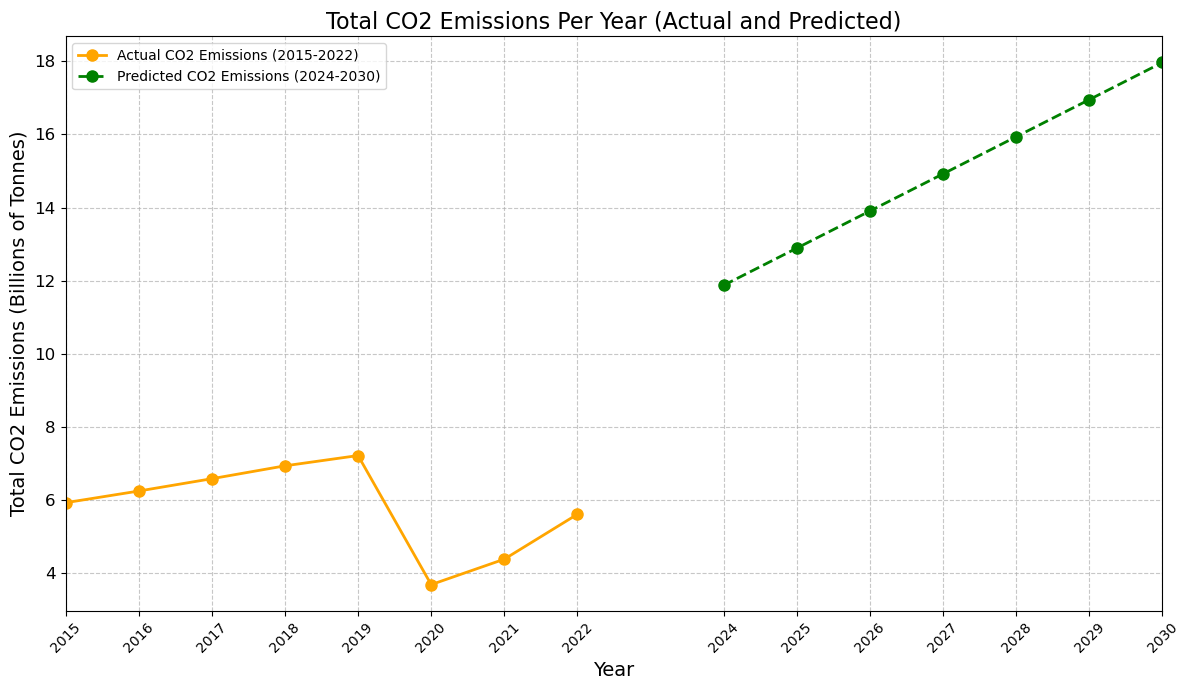

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "/Users/anand/Downloads/Natural_Science_Dataset.xlsx"
excel_data = pd.ExcelFile(file_path)

# Load data from the relevant sheet
sheet_data = pd.read_excel(excel_data, sheet_name='Sheet 1 - AIRTRANS_CO2_17062024')

# Replace '#' with NaN and convert the 'Value' column to numeric, forcing errors to NaN
sheet_data['Value'] = pd.to_numeric(sheet_data['Value'].replace('#', pd.NA), errors='coerce')

# Drop rows where 'TIME' is NaN
sheet_data = sheet_data.dropna(subset=['TIME'])

# Convert TIME to string to ensure we can filter properly
sheet_data['TIME'] = sheet_data['TIME'].astype(str)

# Filter out rows where 'TIME' does not represent a full year
sheet_data = sheet_data[sheet_data['TIME'].str.match(r'^\d{4}$')]

# Drop any remaining rows with NaN values after filtering
sheet_data = sheet_data.dropna(subset=['TIME'])

# Convert TIME to a string format, and extract only the year
sheet_data['YEAR'] = pd.to_datetime(sheet_data['TIME'], errors='coerce').dt.year

# Filter out the year 2023
sheet_data = sheet_data[sheet_data['YEAR'] != 2023]

# Group by year and sum the emissions
total_emissions_per_year = sheet_data.groupby('YEAR')['Value'].sum().reset_index()

# Convert the emissions values to billions for better readability
total_emissions_per_year['Value'] = total_emissions_per_year['Value'] / 1e9

# Predicted values for 2024-2030
predicted_values = {
    'YEAR': [2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'Predicted Value': [1.187602e+10, 1.289105e+10, 1.390609e+10, 1.492112e+10, 1.593616e+10, 1.695119e+10, 1.796623e+10]
}

predicted_df = pd.DataFrame(predicted_values)
predicted_df['Predicted Value'] = predicted_df['Predicted Value'] / 1e9  # Convert to billions

# Plotting
plt.figure(figsize=(12, 7))

# Plot actual emissions
plt.plot(total_emissions_per_year['YEAR'], total_emissions_per_year['Value'], 
         marker='o', color='orange', linestyle='-', linewidth=2, markersize=8, label='Actual CO2 Emissions (2015-2022)')

# Plot predicted emissions
plt.plot(predicted_df['YEAR'], predicted_df['Predicted Value'], 
         marker='o', color='green', linestyle='--', linewidth=2, markersize=8, label='Predicted CO2 Emissions (2024-2030)')

# Add titles and labels
plt.title('Total CO2 Emissions Per Year (Actual and Predicted)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total CO2 Emissions (Billions of Tonnes)', fontsize=14)

# Customize ticks to exclude 2023
plt.xticks([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024, 2025, 2026, 2027, 2028, 2029, 2030], rotation=45)
plt.xlim(2015, 2030)  # Limit the x-axis from 2015 to 2030
plt.yticks(fontsize=12)
plt.grid(linestyle='--', alpha=0.7)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
